# Business Case and Goals

* __Business Case__: Make recommendations to new Microsoft film studio

* __Goals__: Recommendations will all be based on ratings and include the following:
    1. Top 5 genres in the US along with top actors, actresses and directors suitable for that genre
    2. Best film lengths (run times) for those genres
    3. Provide top keywords found in positive and negative critic reviews for guidance


# Library and Data Imports
_______________
* Using the IMDB and Rotten Tomatoes data sets 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## IMDB Data Set Imports

In [2]:
imdb_name_basics = pd.read_csv('zippedData/imdb.name.basics.csv.gz')
imdb_title_akas = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
imdb_title_basics = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
imdb_title_principals = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
imdb_title_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')

## Rotten Tomatoes Data Set Imports

In [3]:
rt_movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t',encoding='latin-1')

# IMDB Data Merging and Cleaning
* General Strategy:
    1. Find top 5 genres in the US by rating
    2. From those genres, filter out actors, actresses and directors who:
        - Are alive (no death year)
        - Are at most 75 years old (not retired and likely to make movies)
    3. Observe the effects of movie length on ratings

## Finding Top 5 Genres

In [4]:
# Combining ratings and title information.  Filtering for US titles.
ratings = imdb_title_basics.merge(imdb_title_ratings, on = "tconst", how = "inner")
ratings = pd.merge(ratings, imdb_title_akas[['title_id','region']],how="left", left_on="tconst", right_on="title_id")
ratings = ratings.loc[ratings['region']=="US"]

In [5]:
# Noticed movies can have more than one genre, which are held as a string and separated by ",".
# Creating a function to split the genres and contain as a list in separate column.
def unpack(df,col,sepp):
    return df[col].fillna("").map(lambda row: row.split(sepp))

In [6]:
# Creating new data frame to start cleaning, unpacking the genres, and subsetting the data
clean_ratings = ratings.loc[ratings['genres'].dropna().index]
clean_ratings['genre_list'] = unpack(clean_ratings,'genres',",")

In [7]:
# Creating a list of unique genres and adding these unique genres as column headers.
unique_genres = []
for genres in clean_ratings['genre_list'].values:
    for genre in genres:
        if genre not in unique_genres:
            unique_genres.append(genre)

for genre in unique_genres:
    clean_ratings[genre] = clean_ratings['genre_list'].apply(lambda x: genre in x)
clean_ratings.columns

Index(['tconst', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'title_id',
       'region', 'genre_list', 'Drama', 'Horror', 'Thriller', 'Documentary',
       'Action', 'Animation', 'Comedy', 'Biography', 'Crime', 'Adventure',
       'Sci-Fi', 'Mystery', 'Romance', 'Family', 'History', 'War', 'Music',
       'Fantasy', 'Sport', 'Western', 'Musical', 'News', 'Reality-TV',
       'Game-Show', 'Adult'],
      dtype='object')

In [8]:
# Creating a list of genres and vote numbers.  Do not want to use genres with too little votes.
average_votes = []
for genre in unique_genres:
    average = clean_ratings.loc[clean_ratings[genre]].loc[:,['numvotes']].mean()
    average_votes.append([genre,average])
vote_outliers = list(map(lambda x: x[1],average_votes))
pd.DataFrame(vote_outliers).describe()

,numvotes
count,25.000000
mean,18647.732529
std,21984.946487
min,37.857143
25%,5816.239092
50%,11870.537313
75%,21508.103786
max,80985.246689


In [9]:
# Setting 5,800 as the minimum number of votes required to be considered a top genre
genres_to_remove = list(filter(lambda x: x[1].mean() < 5800, average_votes))
genres_to_remove = list(map(lambda x: x[0], genres_to_remove))
genres_to_remove

['Documentary', 'Musical', 'News', 'Reality-TV', 'Game-Show', 'Adult']

In [10]:
#Creating a list of genres and ratings.  Removing genres with too little votes and pulling out top 5
average_ratings = []
for genre in unique_genres:
    average = clean_ratings.loc[clean_ratings[genre]].loc[:,['averagerating']].mean()
    average_ratings.append([genre,average])

average_ratings_sorted = list(filter(lambda x: x[0] not in genres_to_remove,average_ratings))
average_ratings_sorted = sorted(average_ratings_sorted,key=lambda x:x[1].mean(), reverse=True)
top_5_genres = list(map(lambda x:x[0],average_ratings_sorted[:5]))
top_5_genres

['Biography', 'History', 'Music', 'Sport', 'Drama']

## Merging and Subsetting Data for Analysis

In [11]:
# Merging the data onto "title_principals" and used as main data set
main_imdb = imdb_title_principals
main_imdb = main_imdb.merge(imdb_name_basics, how = "left", on="nconst")
main_imdb = main_imdb.merge(clean_ratings, how = "left", on = "tconst")

### Creating Subset of main data to clean

In [12]:
# Exploring the available category names and pulling out the ones wanted 
main_imdb['category'].unique()

array(['actor', 'director', 'producer', 'editor', 'actress', 'composer',
       'cinematographer', 'writer', 'self', 'production_designer',
       'archive_footage', 'archive_sound'], dtype=object)

In [13]:
jobs = ['actor','actress', 'director']

In [14]:
# Creating subset with these jobs, filtering again for US region, and dropping unused columns
sub_imdb = main_imdb.loc[(main_imdb['category'].isin(jobs)) & (main_imdb['region'] == "US")]
dropping_cols = []
for genre in unique_genres:
    if genre not in top_5_genres:
        dropping_cols.append(genre)
dropping_cols.append('ordering')
dropping_cols.append('job')
sub_imdb = sub_imdb.drop(dropping_cols, axis=1)
sub_imdb.columns

Index(['tconst', 'nconst', 'category', 'characters', 'primary_name',
       'birth_year', 'death_year', 'primary_profession', 'known_for_titles',
       'primary_title', 'original_title', 'start_year', 'runtime_minutes',
       'genres', 'averagerating', 'numvotes', 'title_id', 'region',
       'genre_list', 'Drama', 'Biography', 'History', 'Music', 'Sport'],
      dtype='object')

### Checking if crew member is deceased or likely retired and handling NA values

In [15]:
#Do not want to use anyone with a non-null death year, or anyone over the age of 75 who is likely retired (Spielberg is 74).
sub_imdb = sub_imdb.loc[(sub_imdb['death_year'].isna() == True) & (sub_imdb['birth_year'] > 1945)]

In [16]:
sub_imdb = sub_imdb.loc[sub_imdb['averagerating'].dropna().index]
# Dropping rows with genre not in our top 5
sub_imdb = sub_imdb.loc[(sub_imdb['Biography'] == True) |
                        (sub_imdb['History'] == True) |
                        (sub_imdb['Music'] == True) |
                        (sub_imdb['Sport'] == True) |
                        (sub_imdb['Drama'] == True) ]

### Cleaning Runtime Minutes

In [17]:
sub_imdb.runtime_minutes.describe()

count    24778.000000
mean       100.027565
std         18.416342
min          7.000000
25%         90.000000
50%         97.000000
75%        109.000000
max        353.000000
Name: runtime_minutes, dtype: float64

In [18]:
sub_imdb['runtime_minutes'].isna().value_counts()

False    24778
True       969
Name: runtime_minutes, dtype: int64

In [19]:
#Less than 5% of the data appears to be NA.  Replacing NA values with Median
median_minutes = sub_imdb['runtime_minutes'].median()
sub_imdb['runtime_minutes'].fillna(median_minutes, inplace=True)
sub_imdb['runtime_minutes'].isna().value_counts()

False    25747
Name: runtime_minutes, dtype: int64

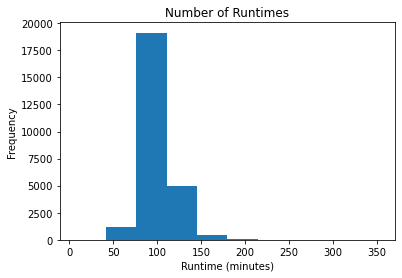

In [20]:
plt.hist(sub_imdb['runtime_minutes'])
plt.xlabel("Runtime (minutes)")
plt.ylabel("Frequency")
plt.title("Number of Runtimes");

In [21]:
#There appears to be outliers towards the right removing outliers using Q1-1.5xIQR amd Q3+1.5xIQR
q1 = sub_imdb['runtime_minutes'].quantile(.25)
q3 = sub_imdb['runtime_minutes'].quantile(.75)
iqr = q3-q1
final_imdb = sub_imdb.loc[(sub_imdb['runtime_minutes'] >= q1-1.5*iqr) &
                          (sub_imdb['runtime_minutes'] <= q3+1.5*iqr)]

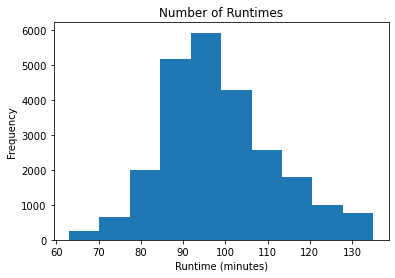

In [22]:
plt.hist(final_imdb['runtime_minutes'])
plt.xlabel("Runtime (minutes)")
plt.ylabel("Frequency")
plt.title("Number of Runtimes");

# IMDB Analysis and Visualization

## Creating functions to extract data

In [23]:
def genre_pull(df,genre):
    return df.loc[df[genre] == True]

def category_pull(df, category):
    return df.loc[df['category'] == category]

def top_categories(df, genre, category):
    data = category_pull(genre_pull(df,genre),category)
    grouped_data = data[['primary_name','averagerating']].groupby('primary_name').mean()
    return grouped_data.sort_values(by = "averagerating",ascending = False).reset_index()   

## Creating dataframes for each category in each genre

In [24]:
# Reminder
print(top_5_genres)
print(jobs)

['Biography', 'History', 'Music', 'Sport', 'Drama']
['actor', 'actress', 'director']


In [67]:
# Biographies
top_bio_actors = top_categories(final_imdb,"Biography","actor")
top_bio_actresses = top_categories(final_imdb,"Biography","actress")
top_bio_directors = top_categories(final_imdb,"Biography","director")
top_bios = [top_bio_actors,top_bio_actresses, top_bio_directors]

# History
top_hist_actors = top_categories(final_imdb,"History","actor")
top_hist_actresses = top_categories(final_imdb,"History","actress")
# Missed a null value here.  Didn't affect the rest of the data
top_hist_actresses = top_hist_actresses.loc[top_hist_actresses['primary_name'] != "Non"]
top_hist_directors = top_categories(final_imdb,"History","director")
top_hists = [top_hist_actors,top_hist_actresses,top_hist_directors]

# Music
top_mus_actors = top_categories(final_imdb,"Music","actor")
top_mus_actresses = top_categories(final_imdb,"Music","actress")
top_mus_directors = top_categories(final_imdb,"Music","director")
top_musics = [top_mus_actors,top_mus_actresses,top_mus_directors]

# Sport
top_sport_actors = top_categories(final_imdb,"Sport","actor")
top_sport_actresses = top_categories(final_imdb,"Sport","actress")
top_sport_directors = top_categories(final_imdb,"Sport","director")
top_sports = [top_sport_actors,top_sport_actresses,top_sport_directors]

# Drama
top_drama_actors = top_categories(final_imdb,"Drama","actor")
top_drama_actresses = top_categories(final_imdb,"Drama","actress")
top_drama_directors = top_categories(final_imdb,"Drama","director")
top_dramas = [top_drama_actors,top_drama_actresses,top_drama_directors]

In [61]:
#defining function to plot
def cat_plot(df_list, genre):
    for i in range(0,len(df_list)):
        if i == 1:
            ylabel = jobs[i].capitalize()
            job = ylabel + "es" 
        else:
            ylabel = jobs[i].capitalize()
            job = ylabel + "s"
        sns.set(rc={'figure.figsize':(5,5)})
        axis = sns.barplot(x="averagerating", y="primary_name", data=df_list[i].head(25), palette="crest")
        axis.set_title("Top Rated "+ job + " For " +  genre)
        axis.set_xlabel("Average Rating")
        axis.set_ylabel(ylabel+" Name")
        axis.set_xlim(7,10)
        
        plt.show();

## Biography Visualization

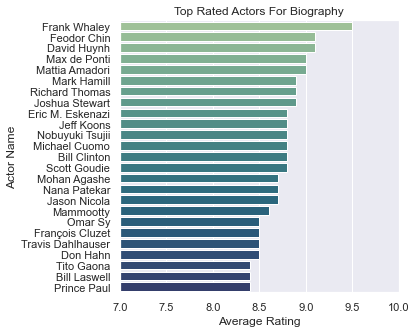

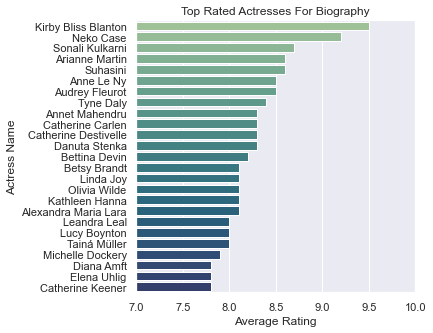

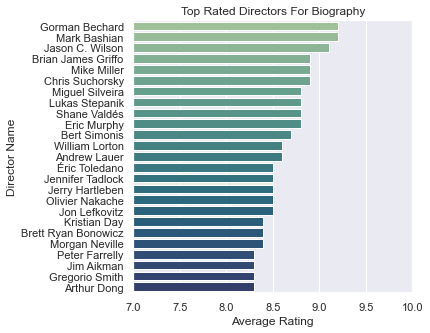

In [62]:
cat_plot(top_bios,"Biography")

## History Visualizations

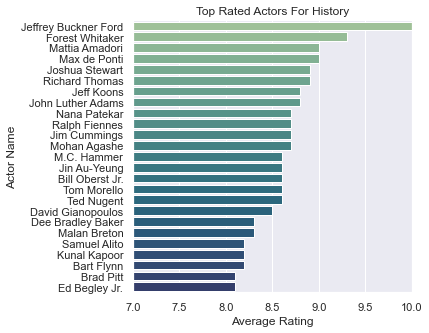

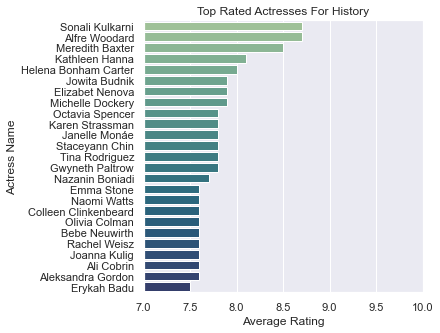

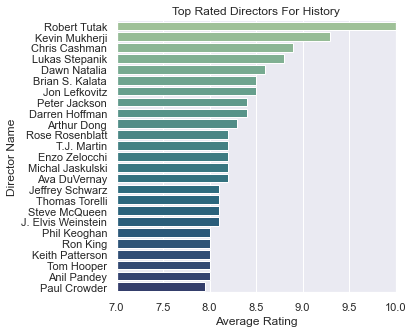

In [63]:
cat_plot(top_hists,"History")

## Music Visualizations

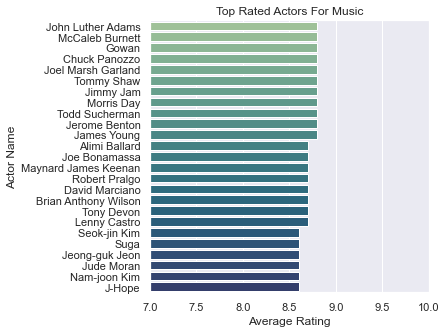

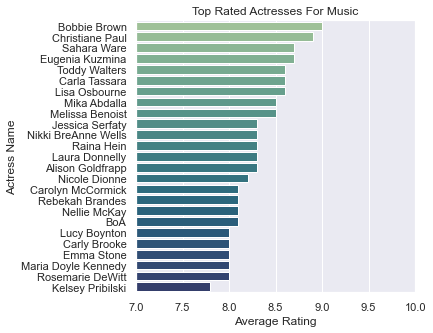

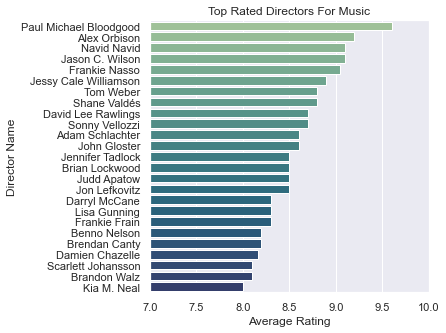

In [64]:
cat_plot(top_musics,"Music")

## Sports Visualizations

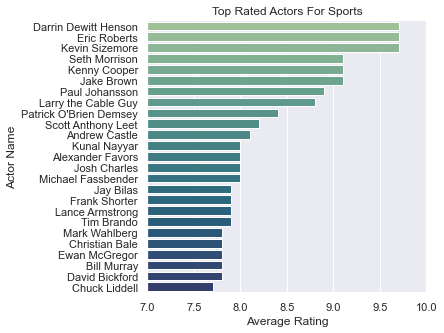

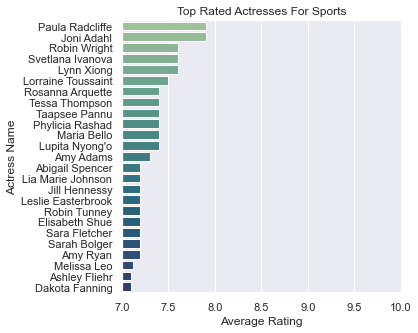

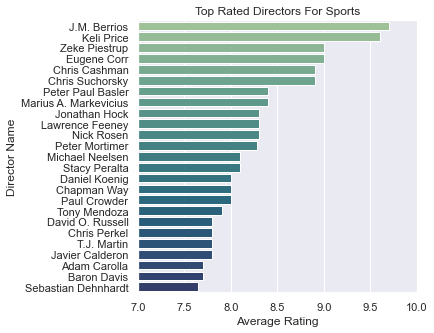

In [65]:
cat_plot(top_sports,"Sports")

## Drama Visualizations

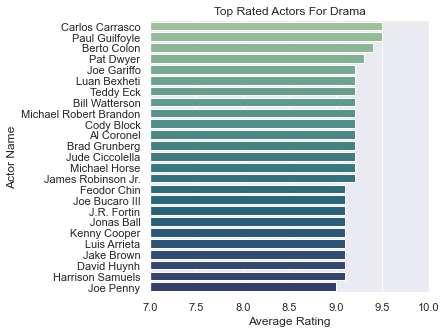

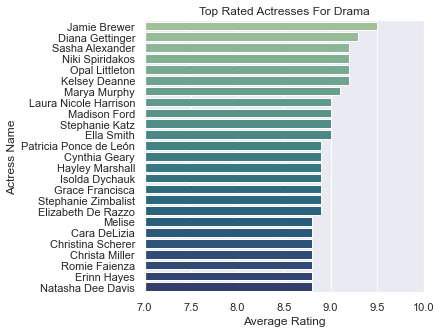

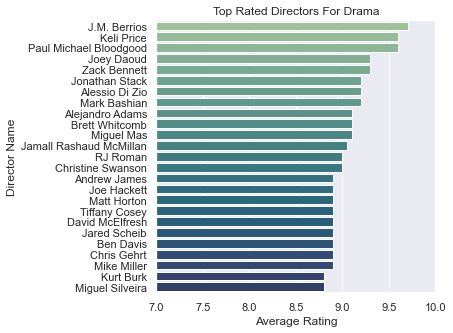

In [66]:
cat_plot(top_dramas,"Drama")

## Run Time Visualizations

### Creating functions and dataframes to plot

In [32]:
runtime_df = final_imdb[['tconst','runtime_minutes','averagerating','Biography','Music','History','Sport','Drama']]
runtime_df = runtime_df.drop_duplicates()

# Create a function to group values for plotting
def genre_grouper(df,genre):
    return genre_pull(df,genre)[['runtime_minutes','averagerating']].groupby('runtime_minutes').mean().sort_values('runtime_minutes')

bio_times = genre_grouper(runtime_df,"Biography")
history_times = genre_grouper(runtime_df,"History")
music_times = genre_grouper(runtime_df,"Music")
sport_times = genre_grouper(runtime_df,"Sport")
drama_times = genre_grouper(runtime_df,"Drama")
runtimes = runtime_df[['runtime_minutes','averagerating']].groupby('runtime_minutes').mean().sort_values('runtime_minutes')

### Plotting

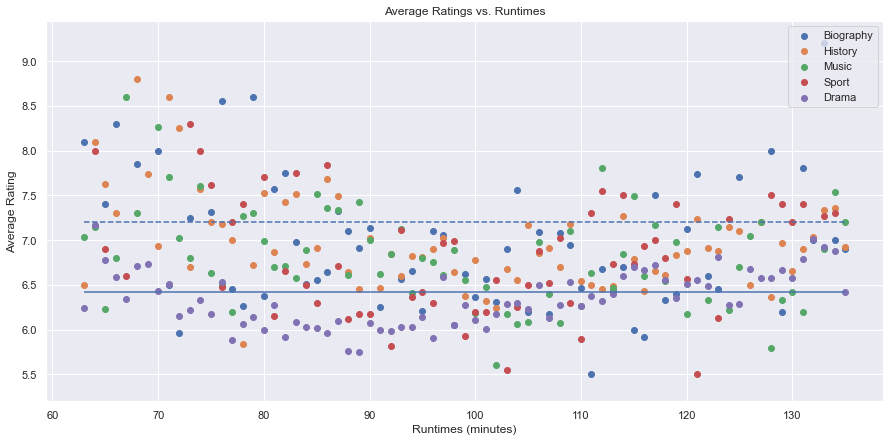

In [33]:
# Overlapping scatter plots
fig, ax1 = plt.subplots(figsize = (15,7))
ax1.scatter(music_times.index,music_times['averagerating'])
ax1.scatter(bio_times.index,bio_times['averagerating'])
ax1.scatter(history_times.index,history_times['averagerating'])
ax1.scatter(sport_times.index,sport_times['averagerating'])
ax1.scatter(drama_times.index,drama_times['averagerating'])
# Showing location of the mean data
ax1.hlines(runtimes['averagerating'].mean(), runtimes.index.min(), runtimes.index.max());
# Going a bit further to highlight high rating values
ax1.hlines(7.2, runtimes.index.min(), runtimes.index.max(), linestyles="dashed");

#labelling and sizing
plt.title("Average Ratings vs. Runtimes")
plt.xlabel("Runtimes (minutes)")
plt.ylabel("Average Rating")
plt.ylim(5.2)
plt.legend(top_5_genres, loc = "upper right")
plt.show()

## __*Findings__
* The data appears to be almost parabolic with the highest ratings found around the shorter or longer ends of runtimes.
* In this set, I find that the highest ratings cluster around less than 90 minutes.

# Rotten Tomatoes Data Merging and Cleaning

* General Strategy:
    1. Clean up ratings values and transform all values to the same scale (out of 10)
    2. Create dataframes of the reviews along with the rating associated to the review where the word is found.
    3. Ensure these words do not contain punctuations or unnecessary stopwords

## Merging

In [34]:
main_rt = rt_reviews.merge(rt_movie_info, how = "left", on = "id")
main_rt.columns

Index(['id', 'review', 'rating_x', 'fresh', 'critic', 'top_critic',
       'publisher', 'date', 'synopsis', 'rating_y', 'genre', 'director',
       'writer', 'theater_date', 'dvd_date', 'currency', 'box_office',
       'runtime', 'studio'],
      dtype='object')

## Cleaning ratings_x containing the rating values I want
* Need to handle the following cleaning issues:
    1. Converting letter grades to a value
    2. Handling mixed numbers such as 3 1/2
    3. Converting x/y into a value out of 10
    
    
* There is more cleaning I could have done to keep more values, but decided against due to personal time constraints
    1. Used a better and more evenly spread letter grade system
    2. The data has single value ratings (not in x/y format).  I wanted to use the fresh/rotten column to determine if the score was out of 5 or out of 10.  If a review between 3-5 was also "fresh", then I assume that the rating is out of 5, otherwise its out of 10.

In [35]:
# creating a subset to work on and dropping na ratings
sub_rt = main_rt
sub_rt = sub_rt.loc[sub_rt['rating_x'].dropna().index]

### Building a function to clean ratings

In [36]:
def rating_clean(value):
    #Letter Grade cleaning, need to improve spread for letters E- and below
    letter_grades = {"A+":10,"A":9,"A-":8,"B+":8,"B":7,"B-":6,"C+":6,"C":5,"C-":4, "D+":4, "D":3,"D-":2,"E+":2, "E":1,"E-":0, "F+":0,"F":0,"F-":0}
    if value in letter_grades:
        return letter_grades[value]

    # Need to handle values like 3 1/2
    if " " in value and "/" in value:
        split_mix = value.split(" ")
        num = split_mix[0]
        den = split_mix[1].split("/")
        number = float(num) + (float(den[0])/float(den[1]))
        return number
    
    if "/" in value:
        split = value.split("/")
        return float(split[0])/float(split[1])*10

### Handling Letter Ratings

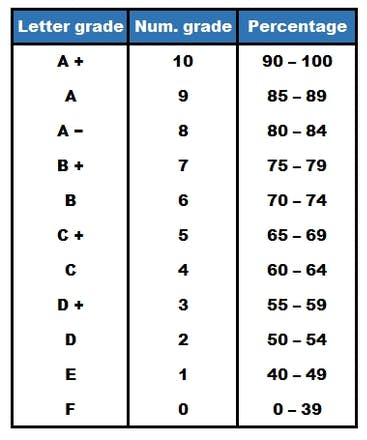

In [37]:
# Used the following chart as a guide but modified to handle missing letter grades
import requests
import IPython.display as Disp
url = 'https://studyportals-cdn2.imgix.net/59773a090d5bd.jpg?w=660&h=440&auto=format,compress&q=40'
Disp.Image(requests.get(url).content)

In [38]:
# Create column for numbered ratings
sub_rt['num_rating'] = sub_rt['rating_x'].apply(lambda x: rating_clean(x))
sub_rt['num_rating'].describe()

count    40156.000000
mean         6.221272
std          2.113994
min          0.000000
25%          5.000000
50%          6.250000
75%          8.000000
max         15.000000
Name: num_rating, dtype: float64

In [39]:
#set ratings above 10 down to 10
sub_rt['num_rating'].loc[sub_rt['num_rating'] > 10] = 10
sub_rt['num_rating'].describe()

C:\Users\Nel-Jiren\Anaconda\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


count    40156.000000
mean         6.220874
std          2.113061
min          0.000000
25%          5.000000
50%          6.250000
75%          8.000000
max         10.000000
Name: num_rating, dtype: float64

## Cleaning Reviews
* Strategy:
    1. drop null reviews
    2. Convert the reviews into a list
    3. Remove the stop words from each review
    4. Create a dictionary for each row containing {words: [list of words], rating: num_rating}
    5. Convert that dictionary into a dataframe for each row
    6. Create a new words dataframe- build by appending each rows rating dataframe to the bottom
    7. group by word on average rating
    8. show results from the top ratings, show results from the bottom rating

In [40]:
# Dropping null values and converting reviews into a list
sub_rt = sub_rt.loc[sub_rt['review'].dropna().index]
sub_rt['reviews_list'] = unpack(sub_rt,'review'," ")

### Importing stopwords from Natural Language Toolkit and removing them from reviews

In [41]:
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
print(stopwords[:5])

['i', 'me', 'my', 'myself', 'we']


In [42]:
# Building a quick function that converts review words to lower case, removes punctuations, and removes stopwords
def remove_stops(texts):
    cleaned = []
    punctuations = ",.!@# $%^&*()?\'\"=-_\\}{][<>:;~`/+*"
    for i in range(len(texts)):
        if texts[i].lower() not in stopwords:
            cleaned.append(texts[i].lower().strip(punctuations))    
    return cleaned

### Create new column with a dataframe containing words and their rating

In [43]:
sub_rt['reviews_list'] = sub_rt['reviews_list'].apply(lambda x: remove_stops(x))

# Creating a function that returns a dataframe
def create_pd(row):
    return pd.DataFrame({'words': row['reviews_list'],'rating':row['num_rating']})

sub_rt['word_ratings'] = sub_rt.apply(lambda x: create_pd(x), axis = 1)
sub_rt['word_ratings'].iloc[0]

,words,rating
0,distinctly,6.0
1,gallows,6.0
2,take,6.0
3,contemporary,6.0
4,financial,6.0
5,mores,6.0
6,one,6.0
7,absurdly,6.0
8,rich,6.0
9,man's,6.0


### Creating new dataframe with all words and ratings by appending each dataframe in the new column

In [44]:
words_df = pd.DataFrame(columns = ['words','rating'])

#### ** This cell takes long to run

In [45]:
for i in range(0,len(sub_rt)):
    words_df = words_df.append(sub_rt['word_ratings'].iloc[i])
words_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412010 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   words   412010 non-null  object 
 1   rating  404082 non-null  float64
dtypes: float64(1), object(1)
memory usage: 9.4+ MB


### Grouping data frame values, sorting and grabbing top/least 25 words
* The grouped data is multi-indexed
* Similar to the number of votes, wanted to focus on words used more than 50 times

In [46]:
grouped_words = words_df.groupby(['words']).agg(['mean','count'])
grouped_words['rating']['count'].astype(int)

count_df = grouped_words['rating']['count'].astype(int)
sorted_words = grouped_words.loc[grouped_words.index.isin(count_df.loc[count_df > 50].index)]
sorted_words = sorted_words['rating']['mean'].sort_values(ascending=False)

In [47]:
positive_words = sorted_words.head(25).reset_index()
negative_words = sorted_words.tail(25).reset_index()

## Positive Words Visualization

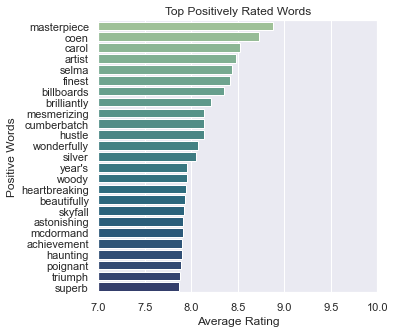

In [68]:
axis_pos = sns.barplot(x="mean", y="words", data=positive_words, palette="crest");
axis_pos.set_title("Top Positively Rated Words")
axis_pos.set_xlabel("Average Rating")
axis_pos.set_ylabel("Positive Words")
axis_pos.set_xlim(7,10)
axis_pos
sns.set(rc={'figure.figsize':(5,5)})
plt.show();

## Negative Words Visualization

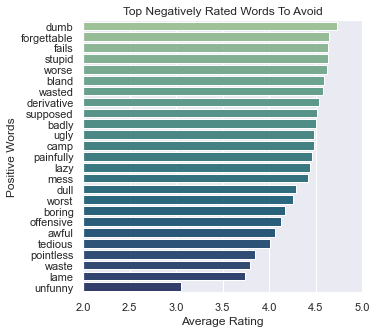

In [69]:
axis_neg = sns.barplot(x="mean", y="words", data=negative_words, palette="crest");
axis_neg.set_title("Top Negatively Rated Words To Avoid")
axis_neg.set_xlabel("Average Rating")
axis_neg.set_ylabel("Positive Words")
axis_neg.set_xlim(2,5)
sns.set(rc={'figure.figsize':(5,5)})
plt.show();

## __*Findings__

* Examples of positive words that stand out include:
    Masterpiece, brilliant, astonishing, superb, haunting, poignant, heartbreaking
* Noticed there are some actor last names such as Cumberbatch


* Examples of negative words include:
    Dumb, forgettable, stupid, bland, lazy, dull, boring, offensive, tedious, pointless, lame, unfunny
    
    
* Recommendation:
    * When working on a film, try to invoke these feelings for positive reviews.  It also appears viewers love movies that make them sad.